## Dataset EDA

In [ ]:
!pip install opendatasets
!pip install tensorflow
!pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
import os
import re
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
from tensorflow.keras.utils import to_categorical

In [ ]:
import opendatasets as od

#when prompted, you need to fill in your Kaggle username and key.
#to obtain these, sign into Kaggle, click your profile picture > Settings > Create New API Token
# this will downlolad a file called kaggle.json that will include your username and key

od.download("https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andreaarifin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images


100%|██████████| 3.10G/3.10G [00:24<00:00, 138MB/s] 


In [ ]:
#check to see if the dataset has loaded on your runtime
dataset_path = './breast-histopathology-images/IDC_regular_ps50_idx5/'

img_paths = glob.glob(os.path.join(dataset_path, '**', '*.png'), recursive=True)

for img in img_paths[:3]:
    print(img)

./breast-histopathology-images/IDC_regular_ps50_idx5/9126/0/9126_idx5_x2901_y1301_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9126/0/9126_idx5_x1151_y701_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9126/0/9126_idx5_x1901_y601_class0.png


# Quick EDA

In [ ]:
neg_imgs = [] #Class = 0 : non-cancerous
pos_imgs = [] #Class = 1 : cancerous

for img in img_paths:
    if img[-5] == '0' :
        neg_imgs.append(img)

    elif img[-5] == '1' :
        pos_imgs.append(img)

print(f"IDC (-): {len(neg_imgs)}")
print(f"IDC (+): {len(pos_imgs)}")
#should print:
# IDC (-): 198738
# IDC (+): 78786

IDC (-): 198738
IDC (+): 78786


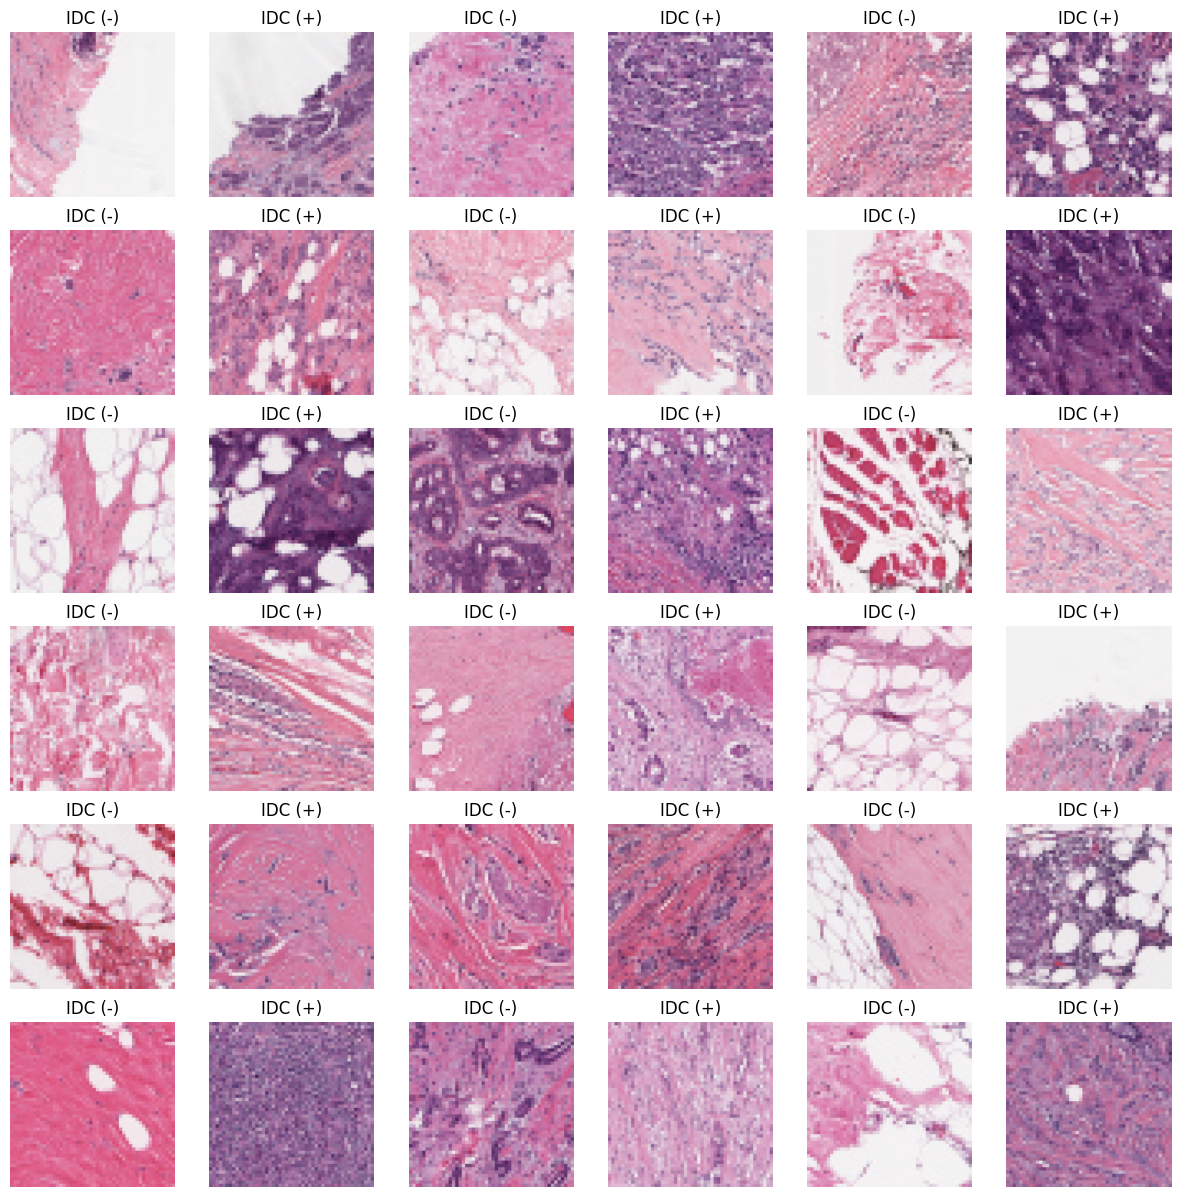

In [ ]:
plt.figure(figsize = (15, 15))
some_non = np.random.randint(0, len(neg_imgs), 18)
some_can = np.random.randint(0, len(pos_imgs), 18)

s = 0
for num in some_non:
    img_obj = image.load_img((neg_imgs[num]), target_size=(100, 100))
    img_array = image.img_to_array(img_obj)

    plt.subplot(6, 6, 2*s+1)
    plt.axis('off')
    plt.title('IDC (-)')
    plt.imshow(img_array.astype('uint8'))
    s += 1

s = 1
for num in some_can:
    img_obj = image.load_img((pos_imgs[num]), target_size=(100, 100))
    img_array = image.img_to_array(img_obj)

    plt.subplot(6, 6, 2*s)
    plt.axis('off')
    plt.title('IDC (+)')
    plt.imshow(img_array.astype('uint8'))
    s += 1

# Patient-level Split

In [ ]:
def parse_filename(path):
    '''
    Function: parse patient IDs and labels from filenames
    Path: image path
    '''
    filename = os.path.basename(path)
    match = re.match(r"(\d+_idx\d+)_x\d+_y\d+_class(\d)\.png", filename)
    if match:
        patient_id = match.group(1)
        label = int(match.group(2))
        return patient_id, label
    else:
        return None, None

data = []
for path in img_paths:
    pid, label = parse_filename(path)
    if pid is not None:
        data.append([path, pid, label])

df = pd.DataFrame(data, columns=["path", "patient_id", "label"])

In [ ]:
num_patients = df['patient_id'].nunique()
print("Number of unique patients:", num_patients)


Number of unique patients: 279


In [ ]:
from sklearn.model_selection import train_test_split

# 0 = patient has only IDC-, 1 = patient has at least one IDC+
patient_labels = df.groupby('patient_id')['label'].max()

RSEED = 5526  # reproducibility

# 60% train, 40% temp (val+test), stratified by patient
train_patients, temp_patients = train_test_split(
    patient_labels.index,
    test_size=0.40,
    stratify=patient_labels,
    random_state=RSEED
)

# Split remaining 40% into 20% val and 20% test, again stratified
temp_labels = patient_labels.loc[temp_patients]
val_patients, test_patients = train_test_split(
    temp_patients,
    test_size=0.50,
    stratify=temp_labels,
    random_state=RSEED
)

# Build dataframes
train_df = df[df['patient_id'].isin(train_patients)]
val_df   = df[df['patient_id'].isin(val_patients)]
test_df  = df[df['patient_id'].isin(test_patients)]

# shuffle each dataframe once to mix label order before TensorFlow loads them
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df   = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df  = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Sanity checks
print(f"✅ Train: {len(train_df)} images, {len(train_patients)} patients")
print(f"✅ Val:   {len(val_df)} images, {len(val_patients)} patients")
print(f"✅ Test:  {len(test_df)} images, {len(test_patients)} patients")

# Confirm no overlap
assert set(train_patients).isdisjoint(val_patients)
assert set(train_patients).isdisjoint(test_patients)
assert set(val_patients).isdisjoint(test_patients)
print("✅ No patient overlap between splits.")

# Confirm both classes exist in every split
for name, subset in (("Train", train_df), ("Val", val_df), ("Test", test_df)):
    counts = subset['label'].value_counts().to_dict()
    print(f"{name} class counts:", counts)
    assert 0 in counts and 1 in counts, f"{name} is missing a class!"


✅ Train: 162017 images, 167 patients
✅ Val:   55116 images, 56 patients
✅ Test:  60391 images, 56 patients
✅ No patient overlap between splits.
Train class counts: {0: 114688, 1: 47329}
Val class counts: {0: 40770, 1: 14346}
Test class counts: {0: 43280, 1: 17111}


# Loading Images

Note:

When you run something in Colab, you’re not running it on your laptop... you’re running it on a big physical computer (a server) inside Google’s data center.

Your Colab notebook doesn’t own that whole machine. instead, Google creates a container (like a tiny virtual sandbox) inside the host.

In [ ]:
from psutil import virtual_memory

#total physical RAM of the Google Cloud host machine that your Colab container is running on
ram = virtual_memory()
print(f"Used: {ram.used / 1e9:.2f} GB")
print(f"Available: {ram.available / 1e9:.2f} GB")
print(f"Total: {ram.total / 1e9:.2f} GB")


Used: 1.54 GB
Available: 11.73 GB
Total: 13.61 GB


In [ ]:
import psutil

#actual available RAM your colab container is using.

def get_container_memory_limit():
    paths = [
        "/sys/fs/cgroup/memory.max",  # cgroup v2
        "/sys/fs/cgroup/memory/memory.limit_in_bytes"  # cgroup v1 (older Colab)
    ]

    for p in paths:
        if os.path.exists(p):
            val = open(p).read().strip()
            if val == "max":
                # Means no limit at host level, fall back to actual available memory
                mem = psutil.virtual_memory().total
                return mem / (1024 ** 3)
            else:
                return int(val) / (1024 ** 3)
    return None

limit_gb = get_container_memory_limit()
if limit_gb:
    print(f"Actual usable container RAM: {limit_gb:.2f} GB")
else:
    print("Could not detect memory limit.")


Actual usable container RAM: 12.67 GB


In [ ]:
#make sure you are running on T4 GPU

gpu_avail = tf.config.list_physical_devices('GPU')
print("Is the GPU available?", len(gpu_avail) > 0)

Is the GPU available? True


In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE #automatically figure out the optimal number of threads or buffer for loading, processing, getting the data
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  #160284 training images / 32 batches = 5009 images/batch

#A note on the WARNING you may receive ("Transparent hugepages are not enabled")
#Transparent hugepages are a Linux kernal feature that helps CPUs and TPUs handle large memory pages more efficiently
#It has no effect on Tensorflow training cause this happens on the GPU

In [ ]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)                 # Reads image bytes from disk (lazy. not all at once)
    img = tf.image.decode_png(img, channels=3)  # Decodes bytes -> H×W×3 tensor (RGB). (Use decode_image for mixed formats.)
    img = tf.image.resize(img, IMG_SIZE)        # Resizes to 224×224 so it matches the model’s expected input
    img = preprocess_input(img)                 # Applies EfficientNetV2 normalization (not just /255)
    label = tf.cast(label, tf.float32)          # scalar 0/1
    return img, label


In [ ]:
def make_dataset(df, shuffle=True):
    paths = df['path'].values
    labels = df['label'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds = make_dataset(val_df, shuffle=False)
test_ds = make_dataset(test_df, shuffle=False)


In [ ]:
def count_classes(dataset):
    counts = np.array([0, 0])
    for _, y in dataset:
        y = y.numpy().astype(int)  # convert floats to ints
        counts += np.bincount(y, minlength=2)
    return counts

#ensuring our training, validation, and test sets are being cached correctly
for split, ds in zip(["train", "val", "test"], [train_ds, val_ds, test_ds]):
    print(split, count_classes(ds))

train [114688  47329]
val [40770 14346]
test [43280 17111]


## Creating the Model

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers, metrics


In [ ]:
# Define image shape and class count
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
CLASS_COUNT = 2

# Load EfficientNetV2S pretrained on ImageNet
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    pooling='avg'   # 'avg' is more stable for fine-tuning
)

#Unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze all but last ~50 layers
    layer.trainable = False

# Classification head
model = tf.keras.Sequential([
    base_model,
    # tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    tf.keras.layers.Dense(
        256,
        kernel_regularizer=regularizers.l2(1e-4),
        # activity_regularizer=regularizers.l1(0.006),
        # bias_regularizer=regularizers.l1(0.01),
        activation='relu'
    ),
    tf.keras.layers.Dropout(rate=0.4, seed=888),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,659,553 (78.81 MB)

 Trainable params: 3,673,793 (14.01 MB)

 Non-trainable params: 16,985,760 (64.80 MB)

## Training the Model

In [ ]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for binary classification.
    gamma > 1 increases focus on hard-to-classify examples.
    alpha adjusts weighting between classes.
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Cross entropy
        ce = -(y_true * tf.math.log(y_pred) +
               (1 - y_true) * tf.math.log(1 - y_pred))

        # Focal term
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = tf.pow(1 - p_t, gamma)

        # Weighted focal loss
        loss_value = alpha * focal_term * ce
        return tf.reduce_mean(loss_value)

    return loss


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        "accuracy",
        metrics.AUC(name="auc"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall")
    ]
)


In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [ ]:
# Check label shapes
for x_batch, y_batch in val_ds.take(1):
    print("Batch X shape:", x_batch.shape)
    print("Batch Y shape:", y_batch.shape)
    # print("X unique vectors:", np.unique(x_batch.numpy(), axis=0))
    print("Y unique vectors:", np.unique(y_batch.numpy(), axis=0))


Batch X shape: (32, 224, 224, 3)
Batch Y shape: (32,)
Y unique vectors: [0. 1.]


In [ ]:
for batch_idx, (x, y) in enumerate(val_ds.take(3)):
    y_vals = y.numpy().astype(int)  # convert floats to ints
    print(f"Batch {batch_idx}: {np.sum(y_vals == 1)} positives out of {y_vals.shape[0]}")


Batch 0: 10 positives out of 32
Batch 1: 8 positives out of 32
Batch 2: 9 positives out of 32


In [ ]:
# neg = (train_df['label'] == 0).sum()
# pos = (train_df['label'] == 1).sum()
# pos_weight = neg / pos  # ~ 2.5-ish
# class_weight = {0: 1.0, 1: float(pos_weight)}

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[es],
    verbose=1,
    # class_weight=class_weight
)


Epoch 1/60
5064/5064 ━━━━━━━━━━━━━━━━━━━━ 832s 151ms/step - accuracy: 0.8162 - auc: 0.8650 - loss: 0.0642 - precision: 0.7077 - recall: 0.6425 - val_accuracy: 0.8772 - val_auc: 0.9300 - val_loss: 0.0452 - val_precision: 0.7768 - val_recall: 0.7413
Epoch 2/60
5064/5064 ━━━━━━━━━━━━━━━━━━━━ 714s 141ms/step - accuracy: 0.8640 - auc: 0.9237 - loss: 0.0442 - precision: 0.7888 - recall: 0.7329 - val_accuracy: 0.8809 - val_auc: 0.9338 - val_loss: 0.0358 - val_precision: 0.7711 - val_recall: 0.7715
Epoch 3/60
5064/5064 ━━━━━━━━━━━━━━━━━━━━ 713s 141ms/step - accuracy: 0.8723 - auc: 0.9327 - loss: 0.0352 - precision: 0.8027 - recall: 0.7490 - val_accuracy: 0.8829 - val_auc: 0.9363 - val_loss: 0.0303 - val_precision: 0.7818 - val_recall: 0.7630
Epoch 4/60
5064/5064 ━━━━━━━━━━━━━━━━━━━━ 716s 141ms/step - accuracy: 0.8785 - auc: 0.9386 - loss: 0.0298 - precision: 0.8113 - recall: 0.7639 - val_accuracy: 0.8862 - val_auc: 0.9372 - val_loss: 0.0270 - val_precision: 0.8160 - val_recall: 0.7267
Epoch 5/

In [ ]:
preds = model.predict(val_ds.take(10))
print("Preds shape:", preds.shape)
print("Unique rows:", np.unique(np.round(preds, 2), axis=0)[:5])
print("Pred range:", preds.min(), preds.max())


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step
Preds shape: (320, 1)
Unique rows: [[0.  ]
 [0.01]
 [0.02]
 [0.03]
 [0.04]]
Pred range: 0.0015447653 0.95667523


In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)


efficientnetv2-s True
dense True
dropout True
dense_1 True


## Evaluating Model Performance

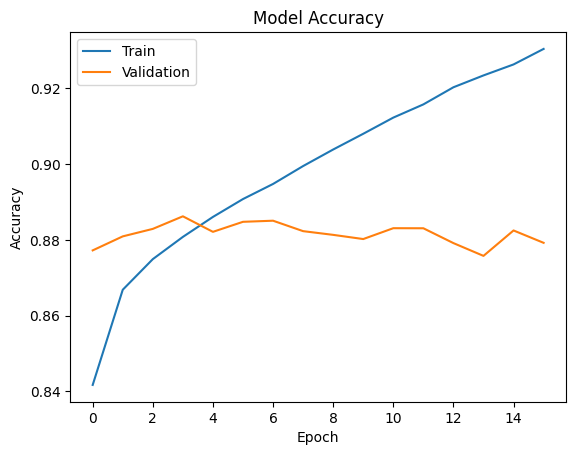

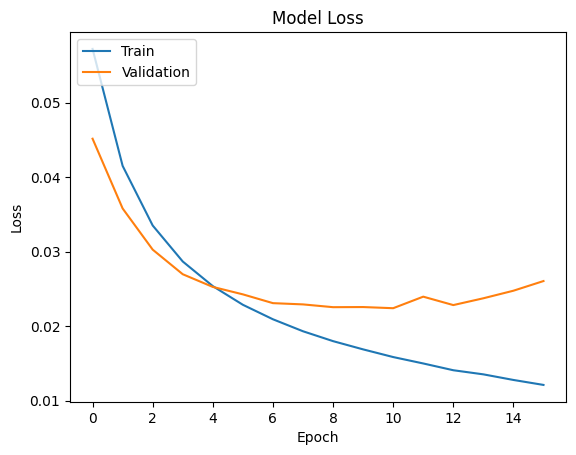

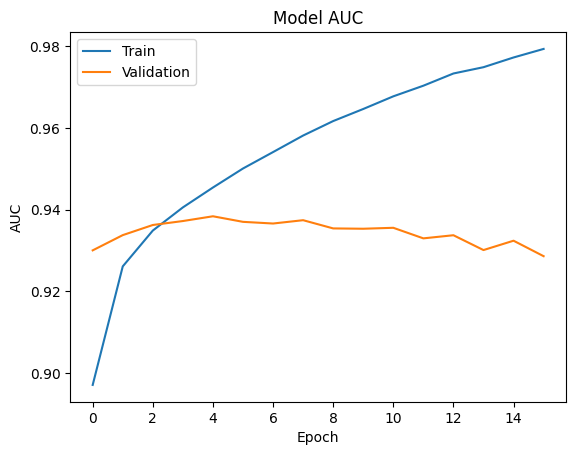

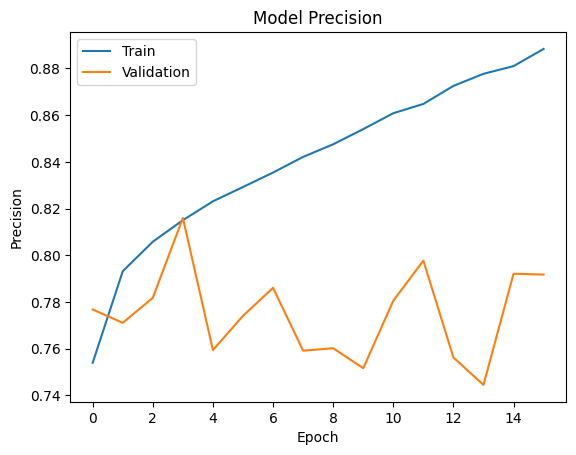

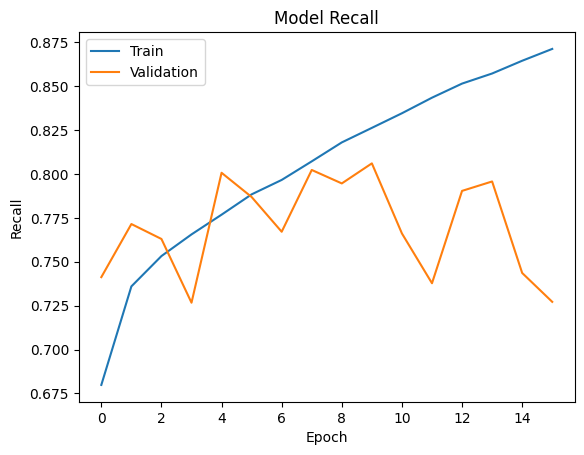

In [ ]:
# --- Accuracy ---
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Loss ---
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- AUC ---
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Precision ---
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Recall ---
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


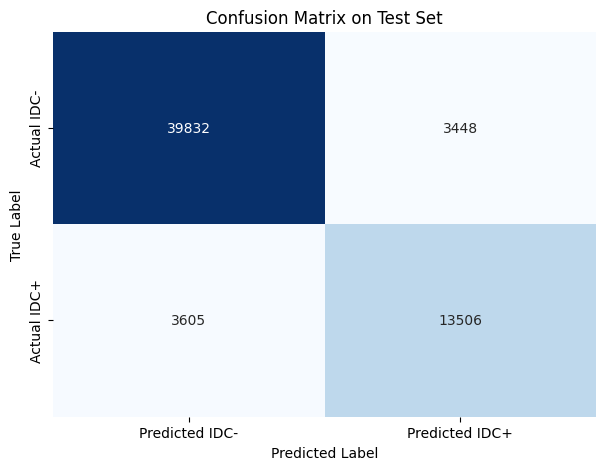


Classification Report:
              precision    recall  f1-score   support

           0      0.917     0.920     0.919     43280
           1      0.797     0.789     0.793     17111

    accuracy                          0.883     60391
   macro avg      0.857     0.855     0.856     60391
weighted avg      0.883     0.883     0.883     60391



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Generate predictions on test set ---
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)   # shape (batch,1)
    preds = preds.squeeze()                      # shape (batch,)

    y_pred.extend((preds >= 0.5).astype(int))    # threshold at 0.5
    y_true.extend(y_batch.numpy().astype(int))   # already 0/1

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Compute confusion matrix ---
conf_mtx = confusion_matrix(y_true, y_pred)

# --- Plot confusion matrix ---
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted IDC-', 'Predicted IDC+'],
            yticklabels=['Actual IDC-', 'Actual IDC+'])
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))


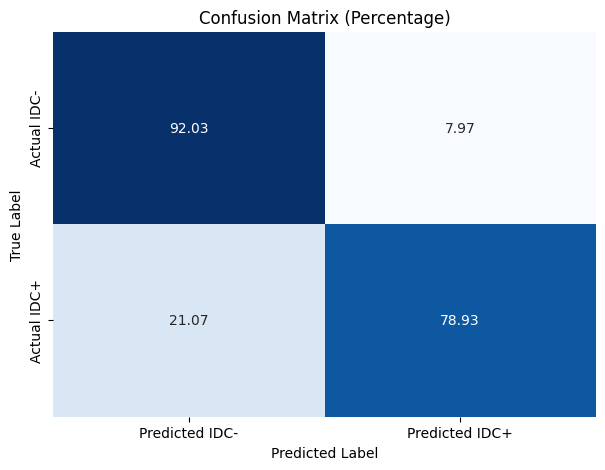

In [ ]:
# --- Convert counts to percentages ---
conf_mtx_percent = conf_mtx.astype('float') / conf_mtx.sum(axis=1)[:, np.newaxis] * 100

# --- Plot percentage confusion matrix ---
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mtx_percent, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=['Predicted IDC-', 'Predicted IDC+'],
            yticklabels=['Actual IDC-', 'Actual IDC+'])
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall: {test_recall:.4f}")


1888/1888 ━━━━━━━━━━━━━━━━━━━━ 181s 96ms/step - accuracy: 0.8824 - auc: 0.9411 - loss: 0.0216 - precision: 0.7939 - recall: 0.7878
✅ Test Accuracy: 0.8832
✅ Test AUC: 0.9426
✅ Test Precision: 0.7966
✅ Test Recall: 0.7893


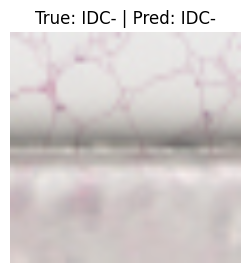

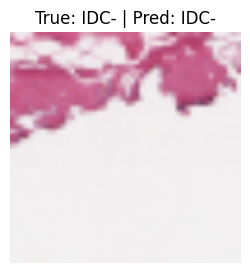

In [ ]:
def show_test_image(dataset, index=0, model=None):
    """Display one sample from a tf.data.Dataset and print true/pred labels."""
    # fetch the exact index-th element from the unbatched dataset
    img = label = None
    for i, (x, y) in enumerate(dataset.unbatch()):
        if i == index:
            img = x.numpy()          # preprocessed image (float)
            label = int(np.argmax(y.numpy()))
            break
    if img is None:
        print(f"Index {index} out of range.")
        return

    # ---- prediction (use the preprocessed img) ----
    pred = None
    if model is not None:
        probs = model.predict(img[None, ...], verbose=0)
        pred = int(np.argmax(probs, axis=1)[0])

    # ---- fix scaling for display ----
    disp = img.copy()
    if disp.dtype != np.uint8:
        if disp.max() > 1.5:         # floats in [0..255] -> [0..1]
            disp = disp / 255.0
        elif disp.min() < 0:         # e.g., [-1..1] -> [0..1]
            m, M = disp.min(), disp.max()
            disp = (disp - m) / (M - m + 1e-8)

    plt.figure(figsize=(3,3))
    plt.imshow(disp)
    title_true = "IDC+" if label == 1 else "IDC-"
    title_pred = "IDC+" if (pred == 1) else "IDC-" if (pred is not None) else "—"
    plt.title(f"True: {title_true} | Pred: {title_pred}")
    plt.axis("off")
    plt.show()

# Example
show_test_image(test_ds, index=200, model=model)
show_test_image(test_ds, index=4563, model=model)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_dir = "/content/drive/MyDrive/CSCI5526/SavedModels"
model.save(f"{save_dir}/FOCALLOSS_model.h5")


In [ ]:
!ls -lh "/content/drive/MyDrive/CSCI5526"
!ls -lh "/content/drive/MyDrive/CSCI5526/SavedModels"


total 4.0K
drwx------ 2 root root 4.0K Nov 22 19:56 SavedModels
total 324M
-rw------- 1 root root 108M Nov 22 14:48 ACTLOSS_model.h5
-rw------- 1 root root 108M Nov 22 19:56 FOCALLOSS_model.h5
-rw------- 1 root root 108M Nov 22 04:02 MANUALWEIGHTS_model.h5
